# Concrete ML Scalability

## Imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression as SklearnLR
from sklearn.svm import LinearSVC as SklearnSVC
from sklearn.tree import DecisionTreeClassifier as SklearnDT
from sklearn.ensemble import RandomForestClassifier as SklearnRF
from xgboost.sklearn import XGBClassifier as SklearnXGB
from sklearn.neural_network import MLPClassifier as SklearnNN

from concrete.ml.sklearn import LogisticRegression as ConcreteLR
from concrete.ml.sklearn import LinearSVC as ConcreteSVC
from concrete.ml.sklearn import DecisionTreeClassifier as ConcreteDT
from concrete.ml.sklearn import RandomForestClassifier as ConcreteRF
from concrete.ml.sklearn import XGBClassifier as ConcreteXGB
from concrete.ml.sklearn import NeuralNetClassifier as ConcreteNN

## Create Datasets

In [2]:
# Create a synthetic dataset
observation_sizes = [503]
feature_sizes = [10, 100, 500, 1000]

datasets = []

# Create datasets with different sizes
for n_obs in observation_sizes:
    for n_feat in feature_sizes:
        X, y = make_classification(n_samples=n_obs, n_features=n_feat)
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=3)
        datasets.append((x_train, x_test, y_train, y_test))

## Benchmark

In [3]:
n_bits = 2

classifiers = [
    ('Logistic Regression', SklearnLR, ConcreteLR),
    ('Linear SVC', SklearnSVC, ConcreteSVC),
    ('Decision Tree', SklearnDT, ConcreteDT),
    ('Random Forest', SklearnRF, ConcreteRF),
    ('XGBoost', SklearnXGB, ConcreteXGB),
    ('Neural Network', SklearnNN, ConcreteNN)
]

In [4]:
results = {'Features': [], 'Classifier': [], 'Inference Time (Sklearn)': [], 'Inference Time (Concrete)': []}

for x_train, x_test, y_train, y_test in datasets:

    # Equivalent hyperparameters
    for clf_name, sklearn_clf, concrete_clf in classifiers:
        if sklearn_clf == SklearnNN:
            sklearn_clf = sklearn_clf(hidden_layer_sizes=(x_train.shape[1],))
            concrete_clf = concrete_clf(verbose=0, **{'module__n_layers': 2, 'module__n_hidden_neurons_multiplier': 1, 'module__n_w_bits': n_bits, 'module__n_a_bits': n_bits})
        else:
            sklearn_hyperparams = sklearn_clf().get_params()
            concrete_hyperparams = concrete_clf().get_params()
            shared_hyperparams = {key: concrete_hyperparams[key] for key in sklearn_hyperparams if key in concrete_hyperparams}
            sklearn_clf = sklearn_clf(**shared_hyperparams)
            concrete_clf = concrete_clf(**shared_hyperparams, n_bits=n_bits)

        # Sklearn
        # Initialize classifier
        clf = sklearn_clf
        # Train classifier
        clf.fit(x_train, y_train)
        # Evaluate classifier
        start = time.time()
        clf.predict(x_test)
        end = time.time()
        eval_single_sklearn = (end - start) / x_test.shape[0]

        # Concrete
        # Initialize classifier
        clf = concrete_clf
        # Train classifier
        clf.fit(x_train, y_train)
        # Compile classifier
        clf.compile(x_train)
        # Evaluate classifier
        start = time.time()
        clf.predict(x_test, fhe='execute')
        end = time.time()
        eval_single_concrete = (end - start) / x_test.shape[0]

        # Save results
        results['Features'].append(x_train.shape[1])
        results['Classifier'].append(clf_name)
        results['Inference Time (Sklearn)'].append(eval_single_sklearn)
        results['Inference Time (Concrete)'].append(eval_single_concrete)

# Evaluate

In [5]:
# results to dataframe
df = pd.DataFrame(results)
df_excluding_nn = df[df['Classifier'] != 'Neural Network']

In [6]:
# Calculate how much slower Concrete is compared to Sklearn
df['Concrete Slowdown'] = df['Inference Time (Concrete)'] / df['Inference Time (Sklearn)']
# Calculate the average slowdown for each classifier
df_avg = df.groupby('Classifier')['Concrete Slowdown'].mean().reset_index()

In [7]:
df

,Features,Classifier,Inference Time (Sklearn),Inference Time (Concrete),Concrete Slowdown
0,10,Logistic Regression,0.000072,0.000448,6.228729
1,10,Linear SVC,0.000063,0.000623,9.822055
2,10,Decision Tree,0.000028,4.434496,155862.776536
3,10,Random Forest,0.000304,2.407743,7920.631634
4,10,XGBoost,0.000662,1.430770,2162.292698
5,10,Neural Network,0.000057,0.718271,12500.611342
6,100,Logistic Regression,0.000057,0.002101,36.816156
7,100,Linear SVC,0.000057,0.002017,35.598878
8,100,Decision Tree,0.000075,3.836734,51249.779193
9,100,Random Forest,0.000303,2.793834,9231.767069


In [8]:
df_avg

,Classifier,Concrete Slowdown
0,Decision Tree,58868.799010
1,Linear SVC,119.962303
2,Logistic Regression,135.244178
3,Neural Network,40413.036675
4,Random Forest,5828.403534
5,XGBoost,1453.594433


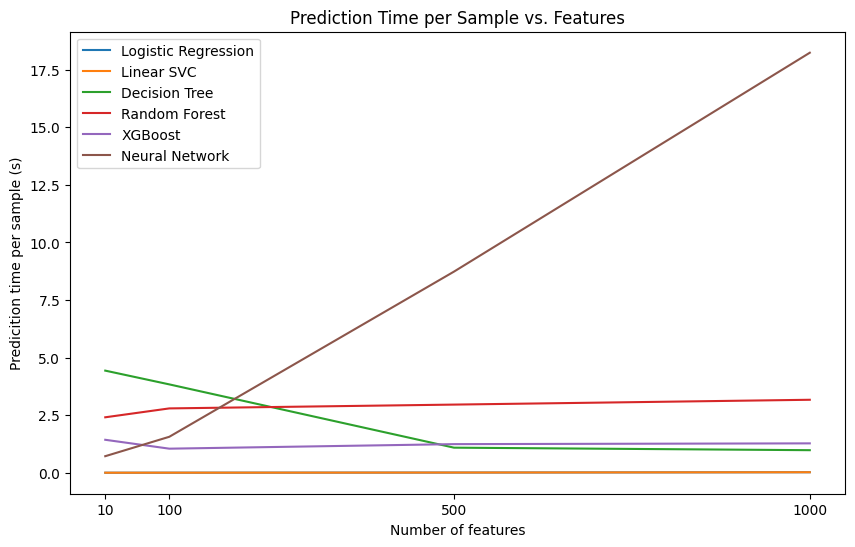

In [9]:
# evaluation time per sample n_feat
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Features', y='Inference Time (Concrete)', hue='Classifier', ci=None)
plt.xticks(feature_sizes)
plt.xlabel('Number of features')
plt.ylabel('Predicition time per sample (s)')
plt.title('Prediction Time per Sample vs. Features')
plt.legend(loc='upper left')
plt.show()

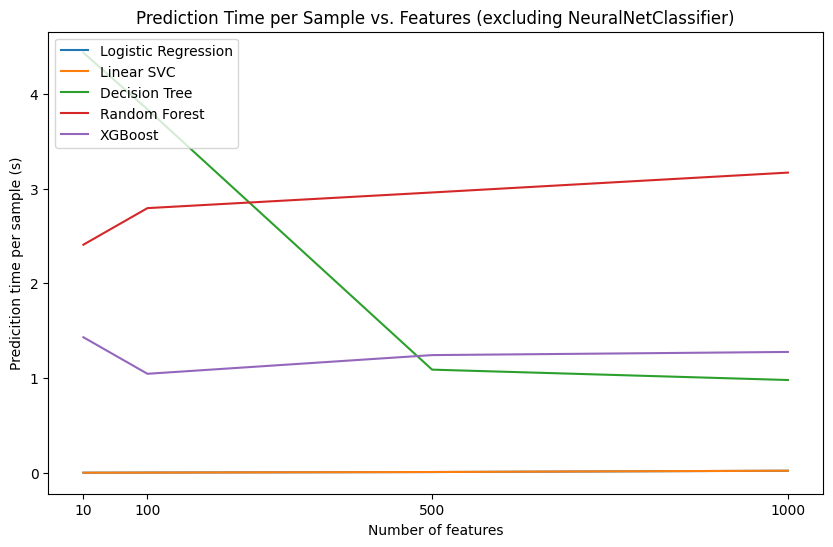

In [10]:
# evaluation time per sample n_feat excluding NeuralNetClassifier
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_excluding_nn, x='Features', y='Inference Time (Concrete)', hue='Classifier', ci=None)
plt.xticks(feature_sizes)
plt.xlabel('Number of features')
plt.ylabel('Predicition time per sample (s)')
plt.title('Prediction Time per Sample vs. Features (excluding NeuralNetClassifier)')
plt.legend(loc='upper left')
plt.show()

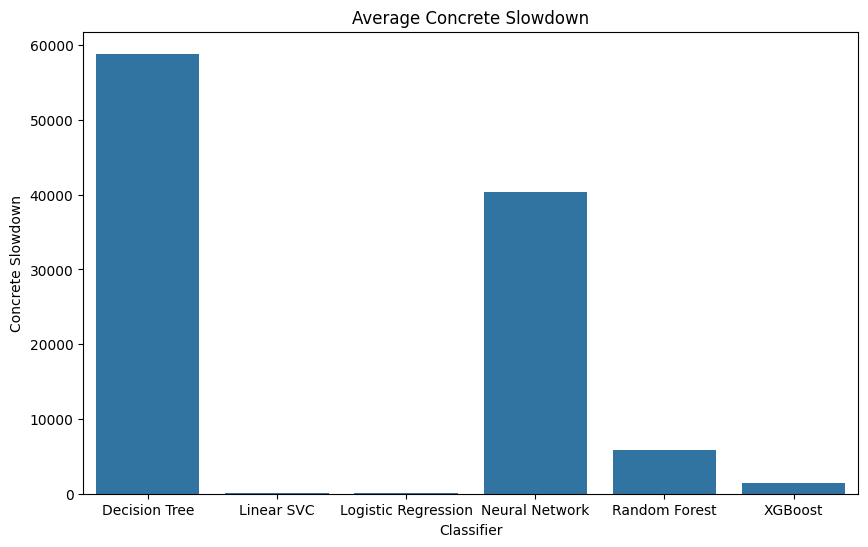

In [11]:
# plot average slowdown
plt.figure(figsize=(10, 6))
sns.barplot(data=df_avg, x='Classifier', y='Concrete Slowdown')
plt.xlabel('Classifier')
plt.ylabel('Concrete Slowdown')
plt.title('Average Concrete Slowdown')
plt.show()

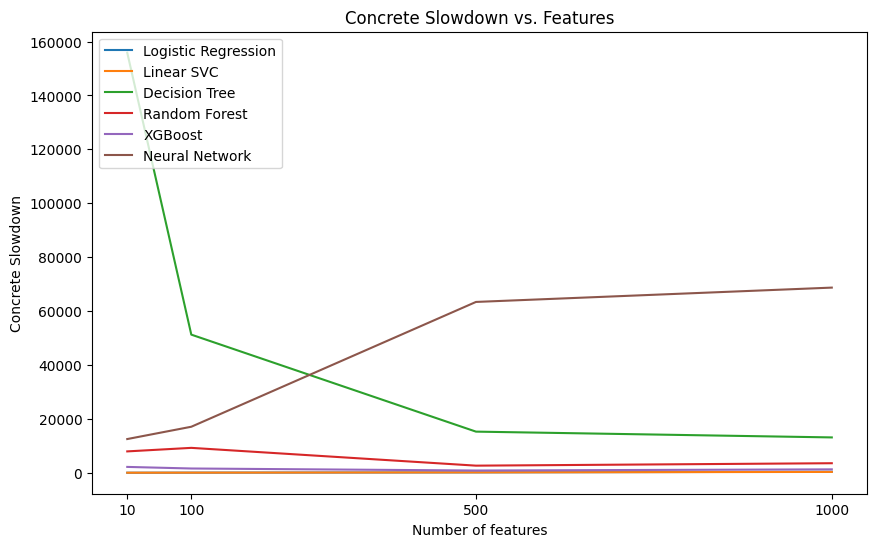

In [12]:
# plot slowdown per sample n_feat
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Features', y='Concrete Slowdown', hue='Classifier', ci=None)
plt.xticks(feature_sizes)
plt.xlabel('Number of features')
plt.ylabel('Concrete Slowdown')
plt.title('Concrete Slowdown vs. Features')
plt.legend(loc='upper left')
plt.show()